# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно.
Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59.
Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

In [1]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')
#удаляем варнинги навсегда, очень бесят при разработке

In [2]:
# random state
RS = 256

In [3]:
try:
    df = pd.read_csv('C:/Users/v.anufrikov/Downloads/Практикум/Churn.csv')  # Локальный путь
except:
    df = pd.read_csv('/datasets/Churn.csv')  # Серверный путь
finally:
    print('Download complete')

Download complete


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


df.info()
> Давайте проверим данные на пустые значение в df, вижу что пустоты есть только в поле Tenure возмжно пустоты связаня с тем что это новые клиенты банка которым не исполнилось год, поэтому можно безопастно заполнить пустоты 0

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

# Очистка данных

In [5]:
df['Tenure'] = df['Tenure'].fillna(0)
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
np.mean(df['Exited'])

0.2037

> Мы видим что соотношение 0 к 1 не очень сбалансированно

# Разбиваем датасет + кодируем

In [7]:
#Кодируем категориальные признаки через OHE
df = pd.get_dummies(df, drop_first=True)

# Разбиваем df

df_train, df_valid_and_test = train_test_split(df, test_size=0.4, random_state=RS, shuffle=True)

df_valid, df_test = train_test_split(df_valid_and_test, test_size=0.5, random_state=RS, shuffle=True)

del df_valid_and_test

# Нормализуем данные

In [8]:
def sampling_scaler(features, numeric, scaler, counter):
    # Стандартизируем признаки
    if counter == 0:
        # отношение количества строк с 0 к 1 Approved
        #rat = len(features.loc[features['Exited']==0])//len(features.loc[features['Exited']==1])

        # выделаем где 1 и повторяем это rat раз
        #df_temp = features.loc[features['Exited']==1]
        #df_temp = df_temp.loc[df_temp.index.repeat(rat)]

        # собираем обратно
        #features = pd.concat([features.loc[features['Exited']==0], df_temp]).sample(frac=1)
        
        # разделяем на
        target = features['Exited']
        features = features.drop('Exited', axis=1)
        
        scaler.fit(features[numeric])
        features[numeric] = scaler.transform(features[numeric])
    else:
        features[numeric] = scaler.transform(features[numeric])
        
        # разделяем на
        target = features['Exited']
        features = features.drop('Exited', axis=1)

    counter += 1
    print(f'counter = {counter}')
    return features, target, counter


> Задаем поля для скеллера

In [9]:
# Инифиализация скеллера
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
counter = 0

In [10]:
features_train, target_train, counter = sampling_scaler(df_train, numeric, scaler, counter)
features_valid, target_valid, counter = sampling_scaler(df_valid, numeric, scaler, counter)
features_test, target_test, counter = sampling_scaler(df_test, numeric, scaler, counter)

counter = 1
counter = 2
counter = 3


# Подготавливаем target в PredefinedSplit


In [ ]:
# Обьединяем 2 выброки так как ищем гиперпарамтеры через кросвалидацию
features_train = np.concatenate((features_train, features_valid))
target_train = np.concatenate((target_train, target_valid))

#ps = PredefinedSplit(target_train)

# Перебираем гиперпараметры через RandomizedSearchCV

In [12]:
def Search(hyperparameter_grid, model):
    # Set up the random search with 4-fold cross validation
    random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               n_iter=25,
                               scoring = {'AUC': 'roc_auc', 'f1': 'f1'},# будем искать по 2м метрикам сразу так как это нужно в задании
                               refit = 'f1',# главенствующая метрика 
                               n_jobs = -1,
                               verbose = 1,
                               return_train_score = True,
                               random_state=RS).fit(features_train,
                                                        target_train)

    print(f'mean_test_f1 = {random_cv.cv_results_["mean_test_f1"]}')
    print()
    print(f'max_test_f1 = {max(random_cv.cv_results_["mean_test_f1"])}')
    print()
    print(f'mean_test_AUC = {random_cv.cv_results_["mean_test_AUC"]}')
    print()
    print(f'max_test_AUC = {max(random_cv.cv_results_["mean_test_AUC"])}')
    print()
    print(f'best_params_ = {random_cv.best_params_}')


> Задаем разброс гиперпараметров

In [13]:
# Гиперпараметры дерева
criterion = ['gini','entropy','log_loss']
splitter = ['best','random']

#Сбалансированный» режим использует значения y для автоматической корректировки весов, обратно пропорциональных частотам классов во входных данных
class_weight = ['balanced_subsample','balanced']

# Loss function to be optimized
loss = ['log_loss', 'deviance', 'exponential']

# Number of trees used in the boosting process
n_estimators = [5, 10, 20, 30, 40, 50, 60, 70, 80, 100]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8, 10]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10, 16,20]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

> Попробуем перебрать гиперпараметры для GradientBoostingClassifier

In [14]:
# Define the grid of hyperparameters to search GradientBoostingClassifier
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = GradientBoostingClassifier(random_state = RS)

# Смотрим на лучшую модель
Search(hyperparameter_grid, model)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
mean_test_f1 = [0.57436286        nan        nan 0.58516157 0.57754956        nan
        nan 0.57010015 0.57179221        nan        nan 0.40111628
 0.40817844 0.57819523 0.57859226 0.56421851        nan 0.57702078
 0.57573622 0.58117426 0.36750216 0.57158167 0.57993215        nan
        nan]

max_test_f1 = 0.5851615658017819

mean_test_AUC = [0.83694468        nan        nan 0.85230723 0.84335557        nan
        nan 0.84631509 0.85040393        nan        nan 0.7935837
 0.78487637 0.84654172 0.83934168 0.85380459        nan 0.84665016
 0.83779032 0.84892118 0.84439428 0.85122529 0.84001043        nan
        nan]

max_test_AUC = 0.8538045935143718

best_params_ = {'n_estimators': 70, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 10, 'loss': 'deviance'}


<div class="alert alert-success">

<h2> Комментарий студента 5 итераци <a class="tocSkip"> </h2>
    
    Понять не могу почему он выводит только последнюю метрику из scoring = {'AUC': 'roc_auc', 'f1': 'f1'} так как мы ведем поиск сразу по нескольки метрикам, если их поменять местами то будет выводится roc_auc вместо f1 
    
     Как вывести в cv_results_ сразу две метрики по которым велся поиск не понятно(

<div class="alert alert-warning">
    <h2> Комментарий ревьюера 6 итерация<a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации💡:</b>

Для обращения к определенной средней метрики можешь использовать
        
        
        random_cv.cv_results_["mean_test_{имя_скорера}"]
        
То есть у тебя 
        
        random_cv.cv_results_["mean_test_f1"]
        random_cv.cv_results_["mean_test_AUC"]
        

<div class="alert alert-success">

<h2> Комментарий студента 7 итерация <a class="tocSkip"> </h2>

Переделал, проверь. Отключил рисование кривой через plot так как метрика и так счиатется норм 
    
    Если это не критичное замечание желтого цвета, то почему работа не принята в таком случае?

<div class="alert alert-success">

<h2> Комментарий ревьюера 7 итерация <a class="tocSkip"> </h2>

    
Потому что критичный комментарий ещё с 5 итерации остался. А тут - рекомендации

> Пробуем перебрать гиперпараметры для RandomForestClassifier

In [15]:
# Define the grid of hyperparameters to search RandomForestClassifier
hyperparameter_grid = {'class_weight': class_weight,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth}

# Create the model to use for hyperparameter tuning
model = RandomForestClassifier(random_state = RS)

# Смотрим на лучшую модель
Search(hyperparameter_grid, model)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
mean_test_f1 = [0.5595535  0.56995858 0.53723863 0.55026297 0.58730189 0.53140894
 0.59622142 0.54692592 0.53039168 0.59094634 0.56346599 0.56317481
 0.53296224 0.53529451 0.54729964 0.56126765 0.57303985 0.54991396
 0.55745629 0.55745629 0.57592078 0.55718551 0.59842746 0.56263481
 0.54185169]

max_test_f1 = 0.5984274575942977

mean_test_AUC = [0.85360217 0.8230713  0.81750293 0.78837943 0.84663179 0.8348878
 0.85005001 0.81884298 0.81636356 0.85097302 0.85222577 0.85208357
 0.81689984 0.81624387 0.8424401  0.85079968 0.85100132 0.84417924
 0.84959255 0.84959255 0.84170428 0.82045998 0.84492602 0.82827003
 0.81820868]

max_test_AUC = 0.8536021726472557

best_params_ = {'n_estimators': 10, 'max_depth': 10, 'class_weight': 'balanced_subsample'}


> Пробуем перебрать гиперпараметры для DecisionTreeClassifier

In [16]:
# Define the grid of hyperparameters to search LogisticRegression
hyperparameter_grid = {'criterion': criterion,
                       'splitter': splitter,
                       'max_depth': max_depth}

# Create the model to use for hyperparameter tuning
model = DecisionTreeClassifier(random_state=RS)

# Смотрим на лучшую модель
Search(hyperparameter_grid, model)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
mean_test_f1 = [0.49526994 0.5132219  0.49542293 0.49684028 0.28568117 0.50865715
 0.49526994        nan 0.49746392 0.50316756        nan        nan
        nan 0.50490546 0.51098216 0.51098921 0.50316756 0.51159714
 0.49757078        nan 0.50245225 0.50490546        nan 0.50316756
        nan]

max_test_f1 = 0.5132218951020737

mean_test_AUC = [0.68466022 0.69623387 0.82725212 0.68478062 0.71297938 0.69396256
 0.68466022        nan 0.68551652 0.69014313        nan        nan
        nan 0.69283183 0.82844948 0.73997797 0.69014313 0.69630535
 0.68617475        nan 0.68669684 0.69283183        nan 0.69014313
        nan]

max_test_AUC = 0.8284494767698934

best_params_ = {'splitter': 'best', 'max_depth': 15, 'criterion': 'gini'}


# Обучаем лучшую модель

In [ ]:
model = GradientBoostingClassifier(loss='deviance',
                                   max_depth=10,
                                   max_features='sqrt',
                                   min_samples_leaf=6,
                                   min_samples_split=10,
                                   n_estimators=70,
                                   random_state=RS).fit(features_train,
                                                        target_train)

#predicted_valid = model.predict(features_valid)
predicted_valid_test = model.predict(features_test)


> Лучшая модель по факту оказалась случайный лес деревьев

In [17]:
# Define the grid of hyperparameters to search RandomForestClassifier
hyperparameter_grid = {'class_weight': class_weight,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth}

# Create the model to use for hyperparameter tuning
model = RandomForestClassifier(random_state = RS,
                              n_estimators = 10, 
                               max_depth = 10, 
                               class_weight = 'balanced_subsample').fit(features_train,target_train)

predicted_valid = model.predict(features_valid)
predicted_valid_test = model.predict(features_test)

# Проверяем модель

In [ ]:
print("Confusion Matrix for valid data:")
print(confusion_matrix(target_valid, predicted_valid))
print()
print("Classification Report for valid data:")
print(classification_report(target_valid, predicted_valid))

# Смотрим отчет и ROC кривую
fpr, tpr, thresholds = roc_curve(target_valid, predicted_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print(f'AUC-ROC = {roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])}')

Confusion Matrix for test data:
[[1396  183]
 [ 161  260]]

Classification Report for test data:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1579
           1       0.59      0.62      0.60       421

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.75      2000
weighted avg       0.83      0.83      0.83      2000



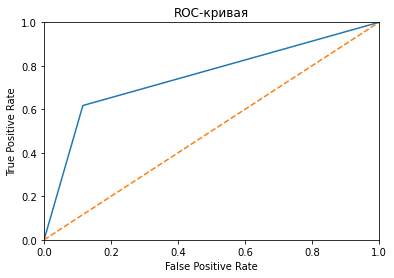



AUC-ROC = 0.850228428648578


In [18]:
print("Confusion Matrix for test data:")
print(confusion_matrix(target_test, predicted_valid_test))
print()
print("Classification Report for test data:")
print(classification_report(target_test, predicted_valid_test))

# Смотрим отчет и ROC кривую
fpr, tpr, thresholds = roc_curve(target_test, predicted_valid_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print()
print()
print(f'AUC-ROC = {roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])}')

# Вывод

1. Мы исследовали наши данные, отбросили лишние признаки и заполнили пропуски
2. Также были обработаны категориальные признаки и стандартизированы числовые
3. Мы исследовали различные модели на имеющемся наборе и столкнулись с проблемой дисбаланса, которую смогли побороть
4. На основании нашего исследования мы выбрали и обучили лучшую модель
5. Это оказался случайный лес с количеством деревьев 42 и глубиной 59 при сбалансированном взвешивании классов.
6. Нам удалось достичь необходимой F1-меры, она составила - 0.9353195
7. Модель хорошо себя показала на тестовой выборке поэтому мы добавили к обучающей выборке еще валидационную и протестировали ее на тестовой, что обеспечило неплохой прирост

В итоге наша модель полностью отвечает как формальным, так и бизнес-требованиям.